# 强化学习与组合优化

## 强化学习解决贪心算法

In [1]:
import numpy as np
import random

# 环境设置
# 图的邻接矩阵 (0 表示无连接，其他数值为路径长度)
graph = np.array([
    [0, 1, 4, 0, 0],
    [1, 0, 2, 6, 0],
    [4, 2, 0, 3, 0],
    [0, 6, 3, 0, 1],
    [0, 0, 0, 1, 0]
])

# 状态和动作
states = list(range(len(graph)))  # 5个节点
actions = list(range(len(graph)))  # 每个节点都可能是目标

# 强化学习参数
alpha = 0.1  # 学习率
gamma = 0.9  # 折扣因子
epsilon = 0.1  # ε-贪心策略

# 初始化 Q 表
q_table = np.zeros((len(states), len(actions)))

# 贪心法求解最短路径
def greedy_path(graph, start, end):
    """通过贪心法寻找从 start 到 end 的路径"""
    path = [start]
    current = start
    while current != end:
        # 找到邻接节点中未访问的最短路径
        neighbors = [(i, graph[current][i]) for i in range(len(graph)) if graph[current][i] > 0 and i not in path]
        if not neighbors:  # 无法继续
            break
        next_node = min(neighbors, key=lambda x: x[1])[0]
        path.append(next_node)
        current = next_node
    return path if current == end else None

# 强化学习训练
episodes = 1000
for episode in range(episodes):
    # 随机初始化状态
    state = random.choice(states)
    
    while True:
        # ε-贪心策略选择动作
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])
        
        # 执行动作，调用组合优化模块
        next_state = action
        path = greedy_path(graph, state, next_state)
        reward = -len(path) if path else -100  # 奖励与路径长度相关，失败时负奖励
        
        # 更新 Q 表
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        
        # 跳到下一个状态
        state = next_state
        if path or episode == episodes - 1:  # 路径成功或最后一轮终止
            break

# 测试训练结果
start_node = 0
end_node = 4
best_action = np.argmax(q_table[start_node])
final_path = greedy_path(graph, start_node, best_action)

print("Q-Table:")
print(q_table)
print(f"从节点 {start_node} 到节点 {end_node} 的最优路径（近似）：{final_path}")


Q-Table:
[[ -6.18952882  -6.21377257  -6.27983692  -6.43891613  -6.18531667]
 [ -6.67868347  -6.58718743  -6.74343099  -6.96179237  -6.77658175]
 [ -6.65655226  -6.66619236  -6.68787009 -42.05815043 -59.07371039]
 [-41.46049346 -42.20751982 -63.41232397  -7.55099909  -7.53539129]
 [ -6.94449349  -6.79648839  -6.91389189  -6.96919971  -6.7792681 ]]
从节点 0 到节点 4 的最优路径（近似）：[0, 1, 2, 3, 4]


多臂老虎机

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# 设置随机种子
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# 定义老虎机环境
class KArmedBandit:
    def __init__(self, k):
        self.k = k
        self.q_star = np.random.normal(0, 1, k)  # 每个老虎机的真实平均奖励
    
    def step(self, action):
        """执行动作（选择一个老虎机）并返回奖励"""
        return np.random.normal(self.q_star[action], 1)  # 奖励服从N(q_star[action], 1)

# 定义DQN网络
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

# 参数和超参数
k = 10  # 10臂老虎机
episodes = 1000
gamma = 0.99
epsilon = 0.1
epsilon_decay = 0.995
min_epsilon = 0.01
learning_rate = 0.001
batch_size = 32
memory_size = 10000

# 初始化环境和DQN
env = KArmedBandit(k)
dqn = DQN(input_size=k, output_size=k)
target_dqn = DQN(input_size=k, output_size=k)
target_dqn.load_state_dict(dqn.state_dict())  # 初始化目标网络
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# 经验回放存储
def store_transition(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# 采样经验回放
def sample_batch():
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        torch.tensor(states, dtype=torch.float32),
        torch.tensor(actions, dtype=torch.int64),
        torch.tensor(rewards, dtype=torch.float32),
        torch.tensor(next_states, dtype=torch.float32),
        torch.tensor(dones, dtype=torch.float32),
    )

# 训练过程
rewards_history = []

for episode in range(episodes):
    state = np.zeros(k)  # 状态初始化为0（无实际状态）
    total_reward = 0

    for step in range(1):
        # 选择动作（ε-贪心）
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(k))
        else:
            with torch.no_grad():
                q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action = torch.argmax(q_values).item()
        
        # 执行动作并获取奖励
        reward = env.step(action)
        next_state = np.zeros(k)  # 状态仍然是0（简化）
        done = True  # 单步任务，直接结束

        # 记录经验
        store_transition(state, action, reward, next_state, done)

        # 累计奖励
        total_reward += reward

        # 状态更新
        state = next_state

        # 更新网络
        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = sample_batch()

            # 计算目标值
            with torch.no_grad():
                next_q_values = target_dqn(next_states)
                max_next_q_values = torch.max(next_q_values, dim=1)[0]
                target = rewards + gamma * max_next_q_values * (1 - dones)

            # 计算当前 Q 值
            q_values = dqn(states)
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

            # 计算损失并优化
            loss = nn.MSELoss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 目标网络软更新
        if episode % 10 == 0:
            target_dqn.load_state_dict(dqn.state_dict())

    # 更新ε
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards_history.append(total_reward)

    # 打印训练进度
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

# 测试DQN
with torch.no_grad():
    state = np.zeros(k)
    q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    best_action = torch.argmax(q_values).item()

print("\n测试结果：")
print(f"每个老虎机的真实奖励均值: {env.q_star}")
print(f"学到的最佳动作: {best_action}, 真实均值: {env.q_star[best_action]:.2f}")


C:\Users\86198\AppData\Local\Temp\ipykernel_12312\4245006009.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  torch.tensor(states, dtype=torch.float32),


Episode 100/1000, Total Reward: 1.45, Epsilon: 0.06
Episode 200/1000, Total Reward: 5.38, Epsilon: 0.04
Episode 300/1000, Total Reward: 1.32, Epsilon: 0.02
Episode 400/1000, Total Reward: 2.04, Epsilon: 0.01
Episode 500/1000, Total Reward: 0.69, Epsilon: 0.01
Episode 600/1000, Total Reward: 3.02, Epsilon: 0.01
Episode 700/1000, Total Reward: 3.22, Epsilon: 0.01
Episode 800/1000, Total Reward: 0.63, Epsilon: 0.01
Episode 900/1000, Total Reward: 3.69, Epsilon: 0.01
Episode 1000/1000, Total Reward: 0.99, Epsilon: 0.01

测试结果：
每个老虎机的真实奖励均值: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
学到的最佳动作: 3, 真实均值: 1.52


## 组合优化建模

### 定义一些常量

In [ ]:
cost_battery = [ 10, -5, 3] #单位时间内的耗电量,分别是dispatching, charging, idling


### 定义车辆与订单

定义汽车

In [ ]:
import numpy as np

# 定义车辆类
class Vehicle:
    def __init__(self, vehicle_id, time, into_city, intercity, decision, battery, orders):
        """
        初始化车辆信息
        data: 一个长度为10的 numpy 数组
        orders: 一个字典，键为订单主码，值为 Order 实例
        """
        self.data = np.array([
            vehicle_id,
            time,
            into_city,
            intercity,
            decision,
            battery
        ],dtype = object)
        self.orders = orders  # 直接管理订单对象, 是一个字典
    
    def get_id(self):
        """获取车辆编号"""
        return self.data[0]
    
    def get_time(self):
        """获取当前时间"""
        return self.data[1]
    
    def update_time(self):
        """更新时间到 t+1"""
        self.data[1] += 1
    
    def get_location(self):
        """获取当前位置，城市内为 False"""
        return self.data[2] != 0
    
    def into_city(self):
        """进入城市"""
        self.data[2] = 0
    
    def intercity(self, v):
        """离开城市，前往城市 v"""
        self.data[2] = self.data[3]
        self.data[3] = v
    
    def update_state(self, decision):
        """更新决策,
        dispacthing: 0
        charging: 1
        idle: 2     """
        self.data[4] = decision
    
    def get_state(self):
        """获取当前决策"""
        return self.data[4]
    
    def update_battery(self):
        """更新电量"""
        self.data[5] -= cost_battery[self.data[4]]
    
    def get_battery(self):
        """获取电量"""
        return self.data[5]
    
    def get_orders(self):
        """获取所有订单对象"""
        return list(self.orders.values())
    
    def delete_order(self, order_id):
        """删除订单"""
        if order_id in self.orders:
            del self.orders[order_id]
    
    def add_order(self,order):
        """增加订单"""
        self.orders[order.get_id()] = order
    
    def get_capacity(self):
        """计算总载客数"""
        return sum(order.get_passenger() for order in self.orders.values())


定义订单

In [12]:
import numpy as np

class Order:
    def __init__(self, order_id, passenger_count, departure, destination, start_time, end_time, virtual_departure):
        # 使用 NumPy 数组存储属性
        self.data = np.array([
            order_id,             # ID
            passenger_count,      # 乘客数
            departure,            # 出发地
            destination,          # 目的地
            start_time,           # 起始时间
            end_time,             # 截止时间
            virtual_departure,    # 虚拟出发点
            0                     # 是否匹配 (0 表示 False, 1 表示 True)
        ], dtype=object)

    def get_id(self):
        """返回订单 ID"""
        return self.data[0]

    def get_passenger(self):
        """返回订单乘客数"""
        return self.data[1]

    def get_route(self):
        """返回出发地和目的地"""
        return self.data[2], self.data[3]

    def get_time(self):
        """获取起始与截止时间"""
        return self.data[4], self.data[5]

    def change_virtual_departure(self, virtual_departure):
        """改变虚拟出发点"""
        self.data[6] = virtual_departure

    def be_matched(self):
        """被匹配"""
        self.data[7] = 1 


汽车与订单的互动

In [14]:
def vehicle_match_order(vehicle, order):
    """车辆匹配订单"""
    order.be_matched()
    vehicle.add_order(order.get_id())


### 定义城市与图

生成图

In [2]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def create_random_directed_graph(num_nodes, edge_prob, weight_range=(1, 10)):
    """
    创建一个随机有向图并生成随机边的权重。
    
    参数:
        num_nodes: 节点数量
        edge_prob: 每两个节点之间存在边的概率（0 到 1）
        weight_range: 权重范围，默认为 (1, 10)
    
    返回:
        G: 随机有向图 (DiGraph)
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v and random.random() < edge_prob:
                weight = random.randint(*weight_range)
                G.add_edge(u, v, weight=weight)
    return G

def visualize_graph(G, figsize=(10, 8)):
    """
    可视化有向图。
    
    参数:
        G: 有向图 (DiGraph)
        figsize: 画布大小，默认为 (10, 8)
    """
    plt.figure(figsize=figsize)  # 调整画布大小
    pos = nx.spring_layout(G)  # 使用 spring 布局
    edge_labels = nx.get_edge_attributes(G, 'weight')  # 获取边的权重
    
    # 绘制图
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color="lightblue", 
        font_size=12, font_weight="bold", arrowsize=20
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)
    
    plt.title("Random Directed Graph", fontsize=16)
    plt.show()

def extract_graph_info(G):
    """
    提取图的节点、边及权重信息。
    
    参数:
        G: 有向图 (DiGraph)
    
    返回:
        nodes: 节点列表
        edges: 边列表
        weights: 边权重字典
    """
    nodes = list(G.nodes())
    edges = list(G.edges())
    weights = nx.get_edge_attributes(G, 'weight')
    return nodes, edges, weights



c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\networkx\drawing\nx_pylab.py:305: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


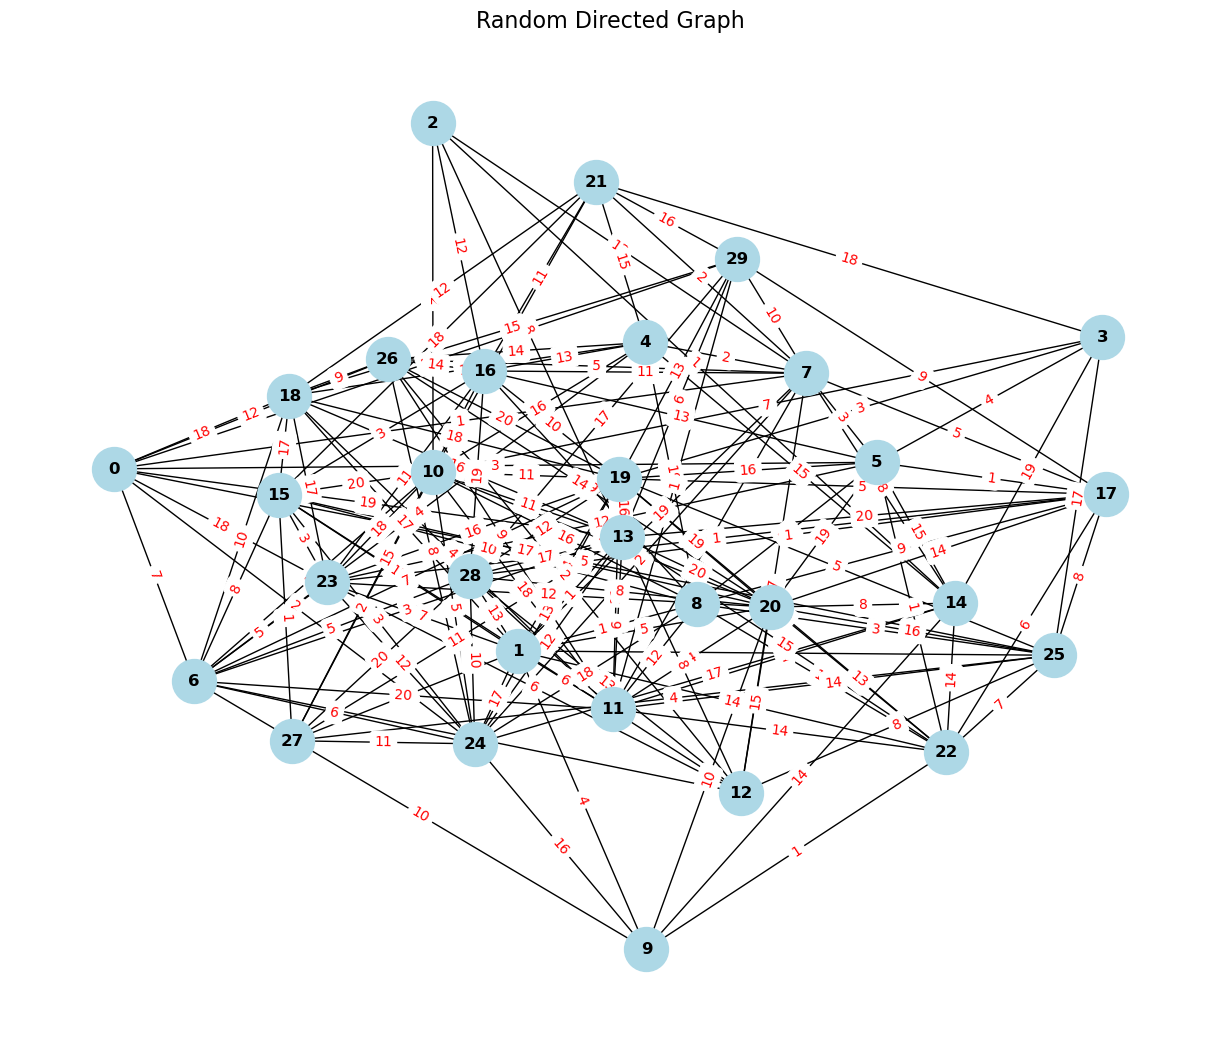

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Edges: [(0, 5), (0, 7), (0, 24), (0, 6), (0, 13), (0, 18), (0, 23), (0, 25), (0, 26), (0, 29), (1, 7), (1, 9), (1, 11), (1, 13), (1, 15), (1, 19), (1, 27), (1, 28), (1, 8), (1, 18), (1, 20), (1, 22), (1, 23), (1, 24), (1, 25), (2, 10), (2, 14), (2, 7), (2, 13), (2, 16), (3, 5), (3, 14), (3, 19), (3, 25), (3, 10), (3, 21), (4, 6), (4, 7), (4, 10), (4, 16), (4, 21), (4, 26), (4, 8), (4, 14), (4, 18), (5, 8), (5, 14), (5, 17), (5, 19), (5, 20), (5, 23), (5, 7), (5, 16), (5, 22), (6, 11), (6, 13), (6, 18), (6, 19), (6, 23), (6, 24), (6, 28), (6, 9), (6, 10), (6, 12), (6, 15), (7, 11), (7, 12), (7, 17), (7, 24), (7, 14), (7, 16), (7, 21), (7, 26), (7, 29), (8, 10), (8, 11), (8, 15), (8, 17), (8, 24), (8, 25), (8, 16), (8, 22), (9, 14), (9, 20), (9, 22), (9, 24), (10, 11), (10, 13), (10, 15), (10, 20), (10, 23), (10, 24), (10, 27), (10, 19), (10, 21), (11, 13), (11, 14), (11,

In [5]:
# 示例：创建并绘制图，同时提取信息
num_nodes = 30
edge_prob = 0.2
weight_range = (1, 20)

G = create_random_directed_graph(num_nodes, edge_prob, weight_range)
visualize_graph(G, figsize=(12, 10))

nodes, edges, weights = extract_graph_info(G)

# 打印信息
print("Nodes:", nodes)
print("Edges:", edges)
print("Weights:", weights)

#### 使用Dijkstra算法存储最短路径

In [6]:
import networkx as nx

def calculate_shortest_paths(G):
    """
    计算图 G 中任意两节点间的最短距离和路径，返回结果。
    
    Args:
    - G (nx.Graph): 无向图。
    
    Returns:
    - results (list): 每对节点的最短路径信息，包含起点、终点、距离和经过的节点。
    """
    nodes = list(G.nodes)
    results = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):  # 确保无重复的城市对
            source = nodes[i]
            target = nodes[j]
            try:
                # 使用 Dijkstra 算法计算最短路径和距离
                length = nx.dijkstra_path_length(G, source, target)
                path = nx.dijkstra_path(G, source, target)
                results.append({"source": source, "target": target, "distance": length, "path": path})
            except nx.NetworkXNoPath:
                # 如果没有路径，跳过
                continue
    return results


In [7]:
G = create_random_directed_graph(num_nodes, edge_prob, weight_range)
result = calculate_shortest_paths(G)
print(result)

[{'source': 0, 'target': 1, 'distance': 3, 'path': [0, 13, 1]}, {'source': 0, 'target': 2, 'distance': 4, 'path': [0, 13, 1, 2]}, {'source': 0, 'target': 3, 'distance': 9, 'path': [0, 13, 27, 25, 3]}, {'source': 0, 'target': 4, 'distance': 4, 'path': [0, 4]}, {'source': 0, 'target': 5, 'distance': 10, 'path': [0, 13, 1, 29, 5]}, {'source': 0, 'target': 6, 'distance': 8, 'path': [0, 13, 27, 25, 6]}, {'source': 0, 'target': 7, 'distance': 9, 'path': [0, 7]}, {'source': 0, 'target': 8, 'distance': 8, 'path': [0, 13, 1, 8]}, {'source': 0, 'target': 9, 'distance': 10, 'path': [0, 4, 20, 9]}, {'source': 0, 'target': 10, 'distance': 7, 'path': [0, 13, 27, 22, 10]}, {'source': 0, 'target': 11, 'distance': 19, 'path': [0, 13, 11]}, {'source': 0, 'target': 12, 'distance': 11, 'path': [0, 13, 27, 22, 12]}, {'source': 0, 'target': 13, 'distance': 1, 'path': [0, 13]}, {'source': 0, 'target': 14, 'distance': 8, 'path': [0, 4, 14]}, {'source': 0, 'target': 15, 'distance': 7, 'path': [0, 4, 20, 15]}, 

提取Dijkstra算法的最短路径

In [8]:
def get_shortest_path_from_result(result, source, target):
    """
    从给定的 result 列表中提取指定城市对的最短路径和距离。

    Args:
    - result (list): 预先计算的所有城市对的最短路径信息。
                     每个元素是一个字典，格式为：
                     {'source': s, 'target': t, 'distance': d, 'path': [path]}。
    - source (int): 起始城市的编号。
    - target (int): 终点城市的编号。

    Returns:
    - dict: 包含最短路径的距离和节点顺序。
            如果 source 和 target 顺序相反，则调整顺序。
            如果无路径，返回 None。
    """
    for entry in result:
        if entry['source'] == source and entry['target'] == target:
            return {'distance': entry['distance'], 'path': entry['path']}
        elif entry['source'] == target and entry['target'] == source:
            # 反向路径，调整顺序
            return {'distance': entry['distance'], 'path': list(reversed(entry['path']))}
    return None


In [9]:
print(get_shortest_path_from_result(result,7,1))

{'distance': 12, 'path': [7, 0, 13, 1]}


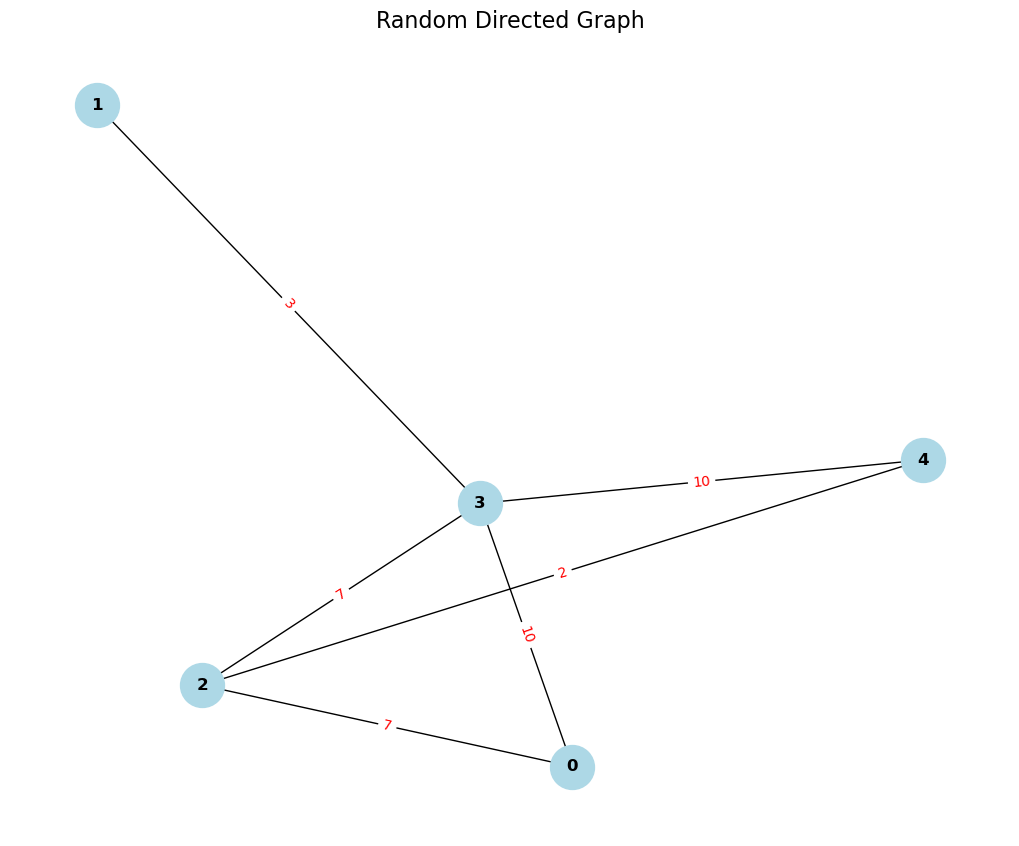

城市 0 的邻接城市: [2, 3]


In [10]:
def get_neighbors(G, city_id):
    """
    获取指定城市的邻接城市。
    
    参数:
        G: 图 (无向图)
        city_id: 城市编号（节点编号）
    
    返回:
        neighbors: 邻接城市列表
    """
    if city_id not in G:
        raise ValueError(f"城市 {city_id} 不在图中")
    return list(G.neighbors(city_id))

G = create_random_directed_graph(5, 0.5)  # 创建一个随机图
visualize_graph(G)  # 可视化图
city_id = 0  # 选择一个城市
neighbors = get_neighbors(G, city_id)
print(f"城市 {city_id} 的邻接城市: {neighbors}")

获取某一城市的领接城市

#### 定义城市

In [ ]:
class City:
    def __init__(self, city_id, neighbor, vehicle_available, charging_capacity, real_departure, virtual_departure):
        self.city_id = city_id
        self.neighbor = neighbor                            # 邻接城市的索引或 ID 列表
        self.vehicle_available = vehicle_available          # 可调度车辆的索引列表
        self.charging_capacity = charging_capacity          # 充电站容量
        self.real_departure = real_departure                # 实际出发点订单的索引列表
        self.virtual_departure = virtual_departure          # 虚拟出发点订单的索引列表

    def get_neighbor(self):
        """获取城市的邻接城市"""
        return self.neighbor

    def get_vehicle_available(self):
        """获取可调度的车辆"""
        return self.vehicle_available

    def add_available_vehicle(self, vehicle_id):
        """增加可调度的车辆"""
        if vehicle_id not in self.vehicle_available:
            self.vehicle_available.append(vehicle_id)

    def delete_available_vehicle(self, vehicle_id):
        """删去不可调度的车辆"""
        if vehicle_id in self.vehicle_available:
            self.vehicle_available.remove(vehicle_id)

    def get_charging_capacity(self):
        """获取充电站容量"""
        return self.charging_capacity

    def get_real_departure(self):
        """获取实际出发点订单"""
        return self.real_departure

    def get_virtual_departure(self):
        """获取虚拟出发城市"""
        return self.virtual_departure

    def update_virtual_departure(self, new_virtual):
        """更新虚拟出发城市"""
        self.virtual_departure = new_virtual


## 调用Gurobi

In [1]:
from gurobipy import *

In [ ]:
from gurobipy import *
class Lower_Layer:

    def __init__(self, num_vehicle, num_order, city_graph, city_node, Vehicle, Order ,name, group):

        """初始化vehicle的决策变量,为4*n的numpy列表,
            即为[intercity, dispatching, charging, idling]
        """
        self.num_vehicle = num_vehicle
        
        """初始化order的决策变量,表示是否被匹配，以及匹配车辆，为2*n列表"""
        self.x_order = num_order

        """传入几个类"""
        self.city_graph = city_graph#类
        self.city_node = city_node  #应当是字典
        self.Vehicle = Vehicle      #应当是字典
        self.Order = Order          #应当是字典

        self.model = Model(name)

    def _add_variable_vehicle(self):

        self.X_Vehicle = self.model.addVars(self.num_vehicle, 4,
                                            vtype=GRB.BINARY, name="var_vehicle")
    
    def _add_variable_vehicle(self):
        """加入订单的决策变量,表示是否被某车辆匹配"""
        self.X_Order = self.model.addVars(self.num_order, self.num_vehicle, 
                                                    vtype=GRB.BINARY, name="var_order")
    
    def get_decision(self):
        return self.X_Vehicle, self.X_order
    
    def _constrain_1(self):
        """先划成分，再扣帽子（指0和1）"""
        """对于在城市中的，能批添加则批添加"""
        constraints_1_1 = [
            (sum(self.X_Vehicle[v, c] for c in range(3)) == 1) for v in range(self.group[0])
        ]
        constraints_1_2 = [
            (self.X_Vehicle[v, 3] == 0) for v in range(self.group[0])
        ]

        self.model.addConstrs(constraints_1_1, name="constraints_1_1")
        self.model.addConstrs(constraints_1_2, name="constraints_1_2")

    def _constrain_2(self):
        """对于在城市间的"""
        constraints_2_1 = [
            (sum(self.X_Vehicle[v, c] for c in range(3)) == 0) for v in range(self.group[0])
        ]
        constraints_2_2 = [
            (self.X_Vehicle[v, 3] == 1) for v in range(self.group[0])
        ]

        self.model.addConstrs(constraints_2_1, name="constraints_2_1")
        self.model.addConstrs(constraints_2_2, name="constraints_2_2")
    
    def _constrian_3(self):
        """要警惕成本，但主要是防止没电"""
        """足电，足车，客之信矣。必不得已而去，于斯三者何先？去电。必不得已而去，于斯二者何先？去车。
        自古皆有死，客无信不立。"""
        battery_demand = {}
        for u in range(self.city_node):
            battery_demand[u] = min(order.battery_demand() for order in self.city_node.get(u).get_virtual_departure())

        constrain_3_1 = []
        constrain_3_2 = []
        constrain_3_3 = []
        for v in range(self.group[0]):
            vehicle = self.Vehicle.get(v)
            for u in range(self.city_node):
                if vehicle.whether_the_city(u):  #是否在该城市
                    if vehicle.get_battery() < battery_demand[u]:         #是否电不够
                        constrain_3_1.append(
                                self.X_Order[order.get_id()] == 0
                        ) # 不准你进行匹配
                        constrain_3_2.append(
                            self.X_Vehicle[v, 0]  == 0 # 这也许比设置后两项和为1更好，如果按照求解顺序的话，那么应当新设立一个组

                        )
                        self.low_battery.append(v) # 将此值传入后续的约束

                    # 如果电可能够，但还是要防止错误匹配
                    else:
                        for order in self.city_node.get(u).get_virtual_departure():
                            if vehicle.get_battery() <= order.battery_demand(): #对于电量小于的，要禁止匹配
                                constrain_3_1.append(
                                    self.X_Order[order.get_id(), vehicle.get_id()] == 0
                                )
                            else:
                                pass
                                # 写一下Dijkstra的路径交并问题
                        
                else:   #对于不存在此城中的，要禁止
                    constrain_3_3.append(
                        self.X_Order[order.get_id(), vehicle.get_id()] == 0 #赋值和判断有什么区别呢？
                    )
                            
        self.model.addConstrs(constrain_3_1, name = "constrains_3_1")
        self.model.addConstrs(constrain_3_2, name = "constrains_3_2")
        self.model.addConstrs(constrain_3_3, name = "constrain_3_3")
    
    def _constrain_4(self):
        """限定订单匹配符合dijkstra结点"""
        constrain_4 = []
        for v in range(self.low_battery):

    


**constrain 1**
$$x^k_u + y^k_u + z^k_u  = 1 $$
$$x^k_{uv} = 0$$
**constrain 2**
$$x^k_u + y^k_u + z^k_u  = 0 $$
$$x^k_{uv} = 1$$
**constrain 3**  

有点多